Importing libraries

In [44]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import json

In [45]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Reading the files into training and validation datasets with a 80%-20% split

In [46]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/DorsalHandVein',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

Found 1104 files belonging to 138 classes.
Using 884 files for training.
Using 220 files for validation.


In [47]:
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)

In [48]:
def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"Total number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Total number of samples in train_dataset: 704 (22 batches of 32)
Total number of samples in validation_dataset: 224 (7 batches of 32)
Total number of samples in test_dataset: 160 (5 batches of 32)


Prefetching data into GPU memory to optimize training process

In [49]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Visualizing some training images

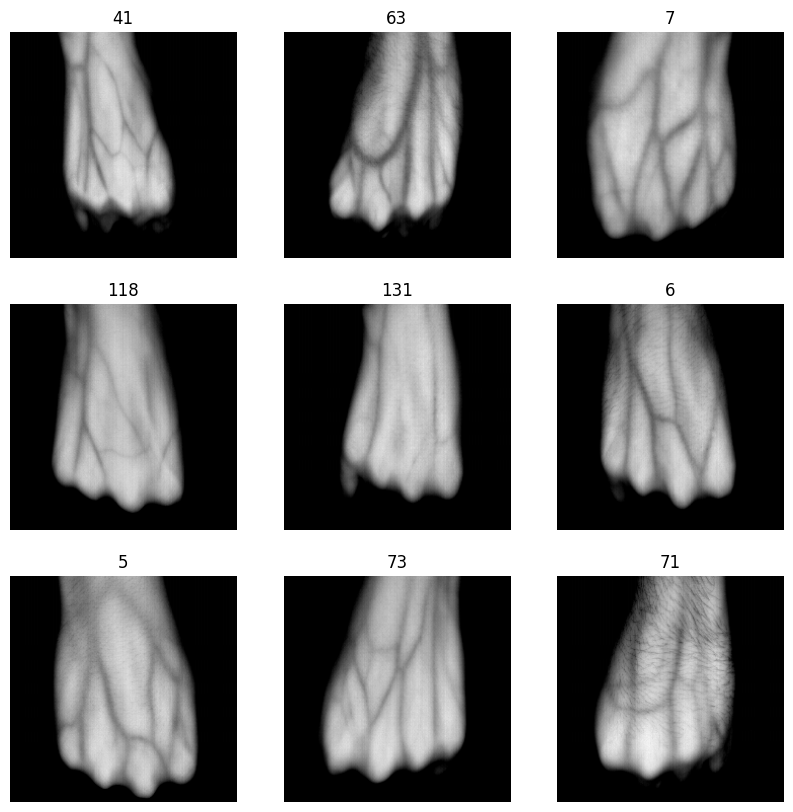

In [50]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Creating data augmentation layer 

In [51]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        # layers.RandomRotation(0.1),
        # layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1),
    ]
)

Visualizing the data augmentations on a random training image

In [52]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_dataset.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

Defining function to return AlexNet Model with reduced number of filters as per research paper

In [53]:
def make_alexnet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Layer 1: Convolutional + Max Pooling
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), strides=(4, 4), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 2: Convolutional + Max Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 3: Three Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


Defining function to return VGG16 Model with reduced number of filters as per research paper

In [54]:
def make_vgg16_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)


Defining function to return VGG19 Model with reduced number of filters as per research paper

In [55]:
def make_vgg19_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)


Define some key constants

In [56]:
num_classes = 138
image_size = (224, 224, 3)
num_epochs = 60

Training each model

In [57]:
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping

models = {
    "AlexNet": make_alexnet_model(input_shape=image_size, num_classes=num_classes),
    "VGG16": make_vgg16_model(input_shape=image_size, num_classes=num_classes),
    "VGG19": make_vgg19_model(input_shape=image_size, num_classes=num_classes),
}

model_histories = {}

for name, model in models.items():
    print(f'\x1b[34mTraining {name} Model...\x1b[0m')
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    start = time.time()
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Wrap model.fit with tqdm for a progress bar
    progress_bar = tqdm(total=num_epochs, position=0, leave=True)
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1)),
            early_stopping
        ]
    )
    progress_bar.close()
    
    model_histories[name] = history
    
    end = time.time()
    print(f'Finished training {name} in {end-start:.2f}s\n')


Training AlexNet Model...


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60
21/22 [===========================>..] - ETA: 0s - loss: 5.0946 - accuracy: 0.0030

  2%|▏         | 1/60 [00:02<02:45,  2.81s/it]

22/22 [==============================] - 3s 85ms/step - loss: 5.0929 - accuracy: 0.0028 - val_loss: 5.0198 - val_accuracy: 0.0182
Epoch 2/60
21/22 [===========================>..] - ETA: 0s - loss: 4.9016 - accuracy: 0.0268

  3%|▎         | 2/60 [00:05<02:31,  2.61s/it]

22/22 [==============================] - 2s 91ms/step - loss: 4.8969 - accuracy: 0.0284 - val_loss: 4.9901 - val_accuracy: 0.0091
Epoch 3/60
21/22 [===========================>..] - ETA: 0s - loss: 4.8149 - accuracy: 0.0223

  5%|▌         | 3/60 [00:07<02:23,  2.52s/it]

22/22 [==============================] - 2s 84ms/step - loss: 4.8092 - accuracy: 0.0227 - val_loss: 4.9663 - val_accuracy: 0.0136
Epoch 4/60
21/22 [===========================>..] - ETA: 0s - loss: 4.7205 - accuracy: 0.0357

  7%|▋         | 4/60 [00:10<02:19,  2.50s/it]

22/22 [==============================] - 2s 84ms/step - loss: 4.7194 - accuracy: 0.0369 - val_loss: 4.9669 - val_accuracy: 0.0273
Epoch 5/60
21/22 [===========================>..] - ETA: 0s - loss: 4.5355 - accuracy: 0.0714

  8%|▊         | 5/60 [00:12<02:11,  2.40s/it]

22/22 [==============================] - 2s 82ms/step - loss: 4.5326 - accuracy: 0.0696 - val_loss: 4.8605 - val_accuracy: 0.0455
Epoch 6/60
21/22 [===========================>..] - ETA: 0s - loss: 4.2772 - accuracy: 0.0967

 10%|█         | 6/60 [00:14<02:10,  2.41s/it]

22/22 [==============================] - 2s 87ms/step - loss: 4.2839 - accuracy: 0.0966 - val_loss: 4.6661 - val_accuracy: 0.0409
Epoch 7/60
21/22 [===========================>..] - ETA: 0s - loss: 3.9833 - accuracy: 0.1443

 12%|█▏        | 7/60 [00:16<02:01,  2.30s/it]

22/22 [==============================] - 2s 74ms/step - loss: 3.9948 - accuracy: 0.1420 - val_loss: 4.4927 - val_accuracy: 0.0591
Epoch 8/60
21/22 [===========================>..] - ETA: 0s - loss: 3.5569 - accuracy: 0.1845

 13%|█▎        | 8/60 [00:18<01:55,  2.22s/it]

22/22 [==============================] - 2s 77ms/step - loss: 3.5815 - accuracy: 0.1818 - val_loss: 4.2287 - val_accuracy: 0.1136
Epoch 9/60
21/22 [===========================>..] - ETA: 0s - loss: 3.1348 - accuracy: 0.2842

 15%|█▌        | 9/60 [00:21<01:51,  2.18s/it]

22/22 [==============================] - 2s 77ms/step - loss: 3.1362 - accuracy: 0.2812 - val_loss: 3.9479 - val_accuracy: 0.1500
Epoch 10/60
21/22 [===========================>..] - ETA: 0s - loss: 2.7617 - accuracy: 0.3571

 17%|█▋        | 10/60 [00:23<02:00,  2.42s/it]

22/22 [==============================] - 3s 113ms/step - loss: 2.7675 - accuracy: 0.3580 - val_loss: 3.5414 - val_accuracy: 0.2136
Epoch 11/60
21/22 [===========================>..] - ETA: 0s - loss: 2.2243 - accuracy: 0.4360

 18%|█▊        | 11/60 [00:26<01:56,  2.38s/it]

22/22 [==============================] - 2s 81ms/step - loss: 2.2166 - accuracy: 0.4418 - val_loss: 3.2948 - val_accuracy: 0.2045
Epoch 12/60
21/22 [===========================>..] - ETA: 0s - loss: 1.9247 - accuracy: 0.5119

 20%|██        | 12/60 [00:28<01:53,  2.36s/it]

22/22 [==============================] - 2s 84ms/step - loss: 1.9276 - accuracy: 0.5114 - val_loss: 3.1011 - val_accuracy: 0.2500
Epoch 13/60
21/22 [===========================>..] - ETA: 0s - loss: 1.5815 - accuracy: 0.5744

 22%|██▏       | 13/60 [00:30<01:47,  2.29s/it]

22/22 [==============================] - 2s 76ms/step - loss: 1.6006 - accuracy: 0.5696 - val_loss: 2.6515 - val_accuracy: 0.3773
Epoch 14/60
22/22 [==============================] - ETA: 0s - loss: 1.3265 - accuracy: 0.6477

 23%|██▎       | 14/60 [00:33<01:50,  2.39s/it]

22/22 [==============================] - 3s 101ms/step - loss: 1.3265 - accuracy: 0.6477 - val_loss: 2.3499 - val_accuracy: 0.3955
Epoch 15/60
20/22 [==========================>...] - ETA: 0s - loss: 1.1297 - accuracy: 0.6844

 25%|██▌       | 15/60 [00:35<01:43,  2.30s/it]

22/22 [==============================] - 2s 73ms/step - loss: 1.1475 - accuracy: 0.6776 - val_loss: 2.4843 - val_accuracy: 0.3773
Epoch 16/60
22/22 [==============================] - ETA: 0s - loss: 0.9254 - accuracy: 0.7500

 27%|██▋       | 16/60 [00:37<01:36,  2.19s/it]

22/22 [==============================] - 2s 76ms/step - loss: 0.9254 - accuracy: 0.7500 - val_loss: 2.1401 - val_accuracy: 0.4000
Epoch 17/60
21/22 [===========================>..] - ETA: 0s - loss: 0.7633 - accuracy: 0.8065

 28%|██▊       | 17/60 [00:39<01:36,  2.25s/it]

22/22 [==============================] - 2s 88ms/step - loss: 0.7789 - accuracy: 0.8011 - val_loss: 1.9670 - val_accuracy: 0.4818
Epoch 18/60
21/22 [===========================>..] - ETA: 0s - loss: 0.6412 - accuracy: 0.8244

 30%|███       | 18/60 [00:42<01:36,  2.29s/it]

22/22 [==============================] - 2s 82ms/step - loss: 0.6553 - accuracy: 0.8196 - val_loss: 1.6819 - val_accuracy: 0.5727
Epoch 19/60
21/22 [===========================>..] - ETA: 0s - loss: 0.4782 - accuracy: 0.8735

 32%|███▏      | 19/60 [00:44<01:32,  2.26s/it]

22/22 [==============================] - 2s 80ms/step - loss: 0.4805 - accuracy: 0.8736 - val_loss: 1.6063 - val_accuracy: 0.5773
Epoch 20/60
21/22 [===========================>..] - ETA: 0s - loss: 0.3947 - accuracy: 0.8973

 33%|███▎      | 20/60 [00:46<01:29,  2.23s/it]

22/22 [==============================] - 2s 76ms/step - loss: 0.4110 - accuracy: 0.8920 - val_loss: 1.4482 - val_accuracy: 0.6591
Epoch 21/60
22/22 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8906

 35%|███▌      | 21/60 [00:48<01:25,  2.20s/it]

22/22 [==============================] - 2s 74ms/step - loss: 0.4195 - accuracy: 0.8906 - val_loss: 1.5661 - val_accuracy: 0.5818
Epoch 22/60
21/22 [===========================>..] - ETA: 0s - loss: 0.3252 - accuracy: 0.9107

 37%|███▋      | 22/60 [00:51<01:30,  2.38s/it]

22/22 [==============================] - 3s 108ms/step - loss: 0.3240 - accuracy: 0.9119 - val_loss: 1.5153 - val_accuracy: 0.6182
Epoch 23/60
21/22 [===========================>..] - ETA: 0s - loss: 0.2689 - accuracy: 0.9286

 38%|███▊      | 23/60 [00:53<01:24,  2.28s/it]

22/22 [==============================] - 2s 75ms/step - loss: 0.2770 - accuracy: 0.9276 - val_loss: 1.4828 - val_accuracy: 0.6364
Epoch 24/60
22/22 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9318

 40%|████      | 24/60 [00:55<01:18,  2.19s/it]

22/22 [==============================] - 2s 73ms/step - loss: 0.2537 - accuracy: 0.9318 - val_loss: 1.4967 - val_accuracy: 0.5955
Epoch 25/60
22/22 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.9574

 42%|████▏     | 25/60 [00:57<01:19,  2.28s/it]

22/22 [==============================] - 3s 94ms/step - loss: 0.2202 - accuracy: 0.9574 - val_loss: 1.3275 - val_accuracy: 0.6727
Epoch 26/60
21/22 [===========================>..] - ETA: 0s - loss: 0.1553 - accuracy: 0.9613

 43%|████▎     | 26/60 [01:00<01:16,  2.26s/it]

22/22 [==============================] - 2s 77ms/step - loss: 0.1592 - accuracy: 0.9616 - val_loss: 1.4417 - val_accuracy: 0.6409
Epoch 27/60
21/22 [===========================>..] - ETA: 0s - loss: 0.1754 - accuracy: 0.9554

 45%|████▌     | 27/60 [01:02<01:16,  2.31s/it]

22/22 [==============================] - 2s 92ms/step - loss: 0.1792 - accuracy: 0.9545 - val_loss: 1.7036 - val_accuracy: 0.5409
Epoch 28/60
20/22 [==========================>...] - ETA: 0s - loss: 0.1394 - accuracy: 0.9703

 47%|████▋     | 28/60 [01:04<01:12,  2.26s/it]

22/22 [==============================] - 2s 76ms/step - loss: 0.1541 - accuracy: 0.9673 - val_loss: 1.2269 - val_accuracy: 0.7000
Epoch 29/60
21/22 [===========================>..] - ETA: 0s - loss: 0.1129 - accuracy: 0.9717

 48%|████▊     | 29/60 [01:06<01:07,  2.18s/it]

22/22 [==============================] - 2s 74ms/step - loss: 0.1204 - accuracy: 0.9702 - val_loss: 1.1631 - val_accuracy: 0.7227
Epoch 30/60
21/22 [===========================>..] - ETA: 0s - loss: 0.1153 - accuracy: 0.9747

 50%|█████     | 30/60 [01:09<01:10,  2.35s/it]

22/22 [==============================] - 3s 96ms/step - loss: 0.1213 - accuracy: 0.9730 - val_loss: 1.1904 - val_accuracy: 0.6909
Epoch 31/60
21/22 [===========================>..] - ETA: 0s - loss: 0.0754 - accuracy: 0.9821

 52%|█████▏    | 31/60 [01:11<01:05,  2.26s/it]

22/22 [==============================] - 2s 75ms/step - loss: 0.0855 - accuracy: 0.9773 - val_loss: 1.1883 - val_accuracy: 0.6864
Epoch 32/60
21/22 [===========================>..] - ETA: 0s - loss: 0.1107 - accuracy: 0.9688

 53%|█████▎    | 32/60 [01:13<01:03,  2.26s/it]

22/22 [==============================] - 2s 83ms/step - loss: 0.1084 - accuracy: 0.9688 - val_loss: 1.1835 - val_accuracy: 0.6955
Epoch 33/60
21/22 [===========================>..] - ETA: 0s - loss: 0.1124 - accuracy: 0.9702

 55%|█████▌    | 33/60 [01:16<01:00,  2.25s/it]

22/22 [==============================] - 2s 76ms/step - loss: 0.1153 - accuracy: 0.9688 - val_loss: 1.2683 - val_accuracy: 0.6545
Epoch 34/60
20/22 [==========================>...] - ETA: 0s - loss: 0.0919 - accuracy: 0.9672

 57%|█████▋    | 34/60 [01:18<00:57,  2.21s/it]

22/22 [==============================] - 2s 79ms/step - loss: 0.0975 - accuracy: 0.9673 - val_loss: 1.1420 - val_accuracy: 0.7045
Epoch 35/60
22/22 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9844

 58%|█████▊    | 35/60 [01:20<00:58,  2.32s/it]

22/22 [==============================] - 3s 85ms/step - loss: 0.0673 - accuracy: 0.9844 - val_loss: 1.2430 - val_accuracy: 0.6955
Epoch 36/60
21/22 [===========================>..] - ETA: 0s - loss: 0.0613 - accuracy: 0.9836

 60%|██████    | 36/60 [01:22<00:55,  2.31s/it]

22/22 [==============================] - 2s 82ms/step - loss: 0.0599 - accuracy: 0.9844 - val_loss: 1.1021 - val_accuracy: 0.7045
Epoch 37/60
22/22 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9702

 62%|██████▏   | 37/60 [01:25<00:53,  2.31s/it]

22/22 [==============================] - 2s 83ms/step - loss: 0.1238 - accuracy: 0.9702 - val_loss: 1.2507 - val_accuracy: 0.6773
Epoch 38/60
21/22 [===========================>..] - ETA: 0s - loss: 0.0698 - accuracy: 0.9836

 63%|██████▎   | 38/60 [01:27<00:48,  2.19s/it]

22/22 [==============================] - 2s 71ms/step - loss: 0.0701 - accuracy: 0.9844 - val_loss: 1.0676 - val_accuracy: 0.7318
Epoch 39/60
21/22 [===========================>..] - ETA: 0s - loss: 0.0714 - accuracy: 0.9851

 65%|██████▌   | 39/60 [01:29<00:46,  2.22s/it]

22/22 [==============================] - 2s 79ms/step - loss: 0.0838 - accuracy: 0.9815 - val_loss: 1.0475 - val_accuracy: 0.7409
Epoch 40/60
21/22 [===========================>..] - ETA: 0s - loss: 0.0758 - accuracy: 0.9777

 67%|██████▋   | 40/60 [01:31<00:43,  2.19s/it]

22/22 [==============================] - 2s 71ms/step - loss: 0.0759 - accuracy: 0.9787 - val_loss: 1.1049 - val_accuracy: 0.7318
Epoch 41/60
21/22 [===========================>..] - ETA: 0s - loss: 0.0512 - accuracy: 0.9881

 68%|██████▊   | 41/60 [01:33<00:41,  2.21s/it]

22/22 [==============================] - 2s 87ms/step - loss: 0.0513 - accuracy: 0.9872 - val_loss: 1.0385 - val_accuracy: 0.7500
Epoch 42/60
21/22 [===========================>..] - ETA: 0s - loss: 0.0418 - accuracy: 0.9911

 70%|███████   | 42/60 [01:36<00:39,  2.21s/it]

22/22 [==============================] - 2s 75ms/step - loss: 0.0406 - accuracy: 0.9915 - val_loss: 1.0412 - val_accuracy: 0.7409
Epoch 43/60
21/22 [===========================>..] - ETA: 0s - loss: 0.0427 - accuracy: 0.9866

 72%|███████▏  | 43/60 [01:38<00:36,  2.17s/it]

22/22 [==============================] - 2s 76ms/step - loss: 0.0439 - accuracy: 0.9858 - val_loss: 1.2210 - val_accuracy: 0.6818
Epoch 44/60
22/22 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9901

 73%|███████▎  | 44/60 [01:41<00:38,  2.44s/it]

22/22 [==============================] - 3s 115ms/step - loss: 0.0468 - accuracy: 0.9901 - val_loss: 1.1770 - val_accuracy: 0.7364
Epoch 45/60
21/22 [===========================>..] - ETA: 0s - loss: 0.0605 - accuracy: 0.9836

 75%|███████▌  | 45/60 [01:43<00:35,  2.36s/it]

22/22 [==============================] - 2s 76ms/step - loss: 0.0697 - accuracy: 0.9815 - val_loss: 1.0867 - val_accuracy: 0.7227
Epoch 46/60
21/22 [===========================>..] - ETA: 0s - loss: 0.0482 - accuracy: 0.9896

 77%|███████▋  | 46/60 [01:45<00:31,  2.23s/it]

22/22 [==============================] - 2s 71ms/step - loss: 0.0464 - accuracy: 0.9901 - val_loss: 1.1031 - val_accuracy: 0.7591


 77%|███████▋  | 46/60 [01:45<00:32,  2.29s/it]


Finished training AlexNet in 105.37s

Training VGG16 Model...


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60
22/22 [==============================] - ETA: 0s - loss: 5.0435 - accuracy: 0.0057

  2%|▏         | 1/60 [00:06<06:34,  6.68s/it]

22/22 [==============================] - 7s 242ms/step - loss: 5.0435 - accuracy: 0.0057 - val_loss: 4.9454 - val_accuracy: 0.0000e+00
Epoch 2/60
22/22 [==============================] - ETA: 0s - loss: 4.9272 - accuracy: 0.0071

  3%|▎         | 2/60 [00:12<05:50,  6.04s/it]

22/22 [==============================] - 5s 225ms/step - loss: 4.9272 - accuracy: 0.0071 - val_loss: 4.9573 - val_accuracy: 0.0000e+00
Epoch 3/60
22/22 [==============================] - ETA: 0s - loss: 4.9256 - accuracy: 0.0099

  5%|▌         | 3/60 [00:17<05:29,  5.78s/it]

22/22 [==============================] - 5s 228ms/step - loss: 4.9256 - accuracy: 0.0099 - val_loss: 4.9700 - val_accuracy: 0.0000e+00
Epoch 4/60
22/22 [==============================] - ETA: 0s - loss: 4.9143 - accuracy: 0.0085

  7%|▋         | 4/60 [00:23<05:18,  5.68s/it]

22/22 [==============================] - 6s 231ms/step - loss: 4.9143 - accuracy: 0.0085 - val_loss: 5.0281 - val_accuracy: 0.0000e+00
Epoch 5/60
22/22 [==============================] - ETA: 0s - loss: 4.9131 - accuracy: 0.0085

  8%|▊         | 5/60 [00:29<05:20,  5.82s/it]

22/22 [==============================] - 6s 254ms/step - loss: 4.9131 - accuracy: 0.0085 - val_loss: 5.0128 - val_accuracy: 0.0000e+00
Epoch 6/60
22/22 [==============================] - ETA: 0s - loss: 4.9086 - accuracy: 0.0156

 10%|█         | 6/60 [00:35<05:15,  5.84s/it]

22/22 [==============================] - 6s 249ms/step - loss: 4.9086 - accuracy: 0.0156 - val_loss: 5.0110 - val_accuracy: 0.0000e+00


 10%|█         | 6/60 [00:35<05:17,  5.88s/it]


Finished training VGG16 in 35.29s

Training VGG19 Model...


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60
22/22 [==============================] - ETA: 0s - loss: 4.9509 - accuracy: 0.0071

  2%|▏         | 1/60 [00:07<07:25,  7.54s/it]

22/22 [==============================] - 8s 283ms/step - loss: 4.9509 - accuracy: 0.0071 - val_loss: 4.9362 - val_accuracy: 0.0000e+00
Epoch 2/60
22/22 [==============================] - ETA: 0s - loss: 4.9300 - accuracy: 0.0043

  3%|▎         | 2/60 [00:13<06:18,  6.53s/it]

22/22 [==============================] - 6s 235ms/step - loss: 4.9300 - accuracy: 0.0043 - val_loss: 4.9415 - val_accuracy: 0.0000e+00
Epoch 3/60
22/22 [==============================] - ETA: 0s - loss: 4.9257 - accuracy: 0.0099

  5%|▌         | 3/60 [00:18<05:43,  6.03s/it]

22/22 [==============================] - 5s 227ms/step - loss: 4.9257 - accuracy: 0.0099 - val_loss: 4.9566 - val_accuracy: 0.0000e+00
Epoch 4/60
22/22 [==============================] - ETA: 0s - loss: 4.9216 - accuracy: 0.0114

  7%|▋         | 4/60 [00:24<05:23,  5.78s/it]

22/22 [==============================] - 5s 229ms/step - loss: 4.9216 - accuracy: 0.0114 - val_loss: 4.9614 - val_accuracy: 0.0000e+00
Epoch 5/60
22/22 [==============================] - ETA: 0s - loss: 4.9206 - accuracy: 0.0099

  8%|▊         | 5/60 [00:28<04:58,  5.43s/it]

22/22 [==============================] - 5s 201ms/step - loss: 4.9206 - accuracy: 0.0099 - val_loss: 4.9764 - val_accuracy: 0.0000e+00
Epoch 6/60
22/22 [==============================] - ETA: 0s - loss: 4.9134 - accuracy: 0.0085

 10%|█         | 6/60 [00:33<04:41,  5.21s/it]

22/22 [==============================] - 5s 202ms/step - loss: 4.9134 - accuracy: 0.0085 - val_loss: 5.0225 - val_accuracy: 0.0000e+00


 10%|█         | 6/60 [00:33<05:04,  5.64s/it]

Finished training VGG19 in 33.84s



Defining function to plot model performance

In [58]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (60,) and (46,)

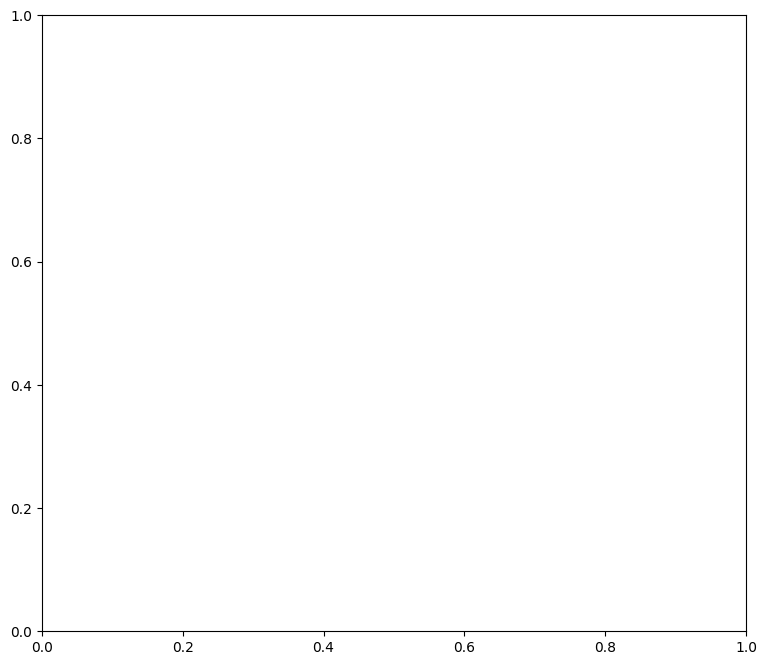

In [59]:
for name, history in model_histories.items():
    plot_model_performance(name, history)

In [60]:
for name, model in models.items():
    test_loss, test_accuracy = model.evaluate(test_dataset)

    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    print(f"Test accuracy: {test_accuracy*100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print()

5/5 [==============================] - 2s 87ms/step - loss: 0.0330 - accuracy: 0.9932
AlexNet Model Results:
Test accuracy: 99.32%
Test loss: 0.0330

5/5 [==============================] - 3s 327ms/step - loss: 4.9355 - accuracy: 0.0000e+00
VGG16 Model Results:
Test accuracy: 0.00%
Test loss: 4.9355

5/5 [==============================] - 2s 49ms/step - loss: 4.9308 - accuracy: 0.0000e+00
VGG19 Model Results:
Test accuracy: 0.00%
Test loss: 4.9308



In [18]:
for name, model in models.items():
    model.save(f'Saved Models/DorsalVein/{name}.keras')
    print(f'Saved {name} Model')

for name, model in model_histories.items():
    with open(f'Model Histories/{name}.json', 'w') as json_file:
        json.dump(history.history, json_file)


Saved AlexNet Model
Saved VGG16 Model
Saved VGG19 Model


In [19]:
# img = keras.utils.load_img(
#     "Full Data/roi/001-M/01/001_L_1_1.png", target_size=image_size
# )
# plt.imshow(img)

# img_array = keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# predictions = model.predict(img_array)
# predicted_class_index = tf.argmax(predictions[0]).numpy()
# print('Predicted Class:', predicted_class_index)